In [5]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import matplotlib.pyplot as plt
import tigge_scripts

import numpy as np
import warnings
import pkg_resources
from datetime import datetime as dt, timedelta
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mlib
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
# XML TC track data path
data_path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED_WRFsen/storage/tigge/'
data_file = data_path+'z_tigge_c_kwbc_20160703120000_GEFS_glob_prod_esttr_glo.xml'

# Parse XML track file
tree = ET.parse(data_file)
root = tree.getroot()

# Data converted to pandas dataframes

In [3]:
df = tigge_scripts.save_tigge_gefs_tracks(root)

## What TCs are in the file?

In [4]:
print(df['Cyclone Name'].unique(), df['Basin'].unique())

['Agatha' 'Nepartak' 'Blas'] ['EP' 'WP']


## Read GEFS Forecasts for NEPARTAK

In [6]:
nepartak = df[df['Cyclone Name']=='Nepartak']

In [7]:
lat_memb1 = nepartak[nepartak['Ensemble Member']==str(1)]['Latitude (deg N)']
lon_memb1 = nepartak[nepartak['Ensemble Member']==str(1)]['Longitude (deg E)']

In [42]:
np.array([len(obj) for obj in (lon)]).min(),np.array([len(obj) for obj in (lat)]).min()

(31, 31)

## Plot em'

In [29]:
class plot:
    def __init__(self,proj):
        self.proj = proj

    def init_cartopy(self,proj,**kwargs):
        return getattr(ccrs, proj)(**kwargs)

    def set_background(self,res,alpha,oceancolor,landcolor,lw,lc):
        # Initiate dictionary
        propdict = {}

        # Populate plot setting dictionary
        propdict['res'] = res #resolution
        propdict['alpha'] = alpha
        propdict['ocean_color'] = oceancolor
        propdict['land_color'] = landcolor
        propdict['lw'] = lw #linewidth
        propdict['lc'] = lc #linecolor
        
        # fill oceans if specified
        self.ax.set_facecolor(propdict['ocean_color'])
        ocean_mask = self.ax.add_feature(cfeature.OCEAN.with_scale(propdict['res']), facecolor=propdict['ocean_color'], edgecolor='face')
        lake_mask = self.ax.add_feature(cfeature.LAKES.with_scale(propdict['res']), facecolor=propdict['ocean_color'], edgecolor='face')
        continent_mask = self.ax.add_feature(cfeature.LAND.with_scale(propdict['res']), facecolor=propdict['land_color'], edgecolor='face')

        # draw geography
        if propdict['alpha'] > 0:
            states = self.ax.add_feature(cfeature.STATES.with_scale(propdict['res']), linewidths=propdict['lw'], linestyle='solid', edgecolor=propdict['lc'],alpha=propdict['alpha'])
            countries = self.ax.add_feature(cfeature.BORDERS.with_scale(propdict['res']), linewidths=propdict['lw'], linestyle='solid', edgecolor=propdict['lc'],alpha=propdict['alpha'])
            coastlines = self.ax.add_feature(cfeature.COASTLINE.with_scale(propdict['res']), linewidths=propdict['lw'], linestyle='solid', edgecolor=propdict['lc'],alpha=propdict['alpha'])
    
    def plot_init(self, ax, plot_geography=True):
        r"""
        Initializes the plot by creating a cartopy and axes instance, and add background.
        """
        #Set default map properties
        default_map_prop = {'res': '50m', 'land_color': '#FBF5EA', 'ocean_color': '#EDFBFF',
                            'linewidth': 0.5, 'linecolor': 'k', 'figsize': (14, 9),
                            'dpi': 400, 'plot_gridlines': True, 'alpha': 1}
        self.map_prop = default_map_prop

        # create cartopy projection
        self.init_cartopy(proj='PlateCarree', central_longitude=0.0)

        # create figure
        if ax is None:
            self.fig = plt.figure(
                figsize=self.map_prop['figsize'], dpi=self.map_prop['dpi'])
            self.ax = plt.axes(projection=self.proj)
        else:
            fig_numbers = [
                x.num for x in mlib._pylab_helpers.Gcf.get_all_fig_managers()]
            if len(fig_numbers) > 0:
                self.fig = plt.figure(fig_numbers[-1])
            else:
                self.fig = plt.figure(
                    figsize=self.map_prop['figsize'], dpi=self.map_prop['dpi'])
            self.ax = ax

        # Attach geography to plot, lat/lon lines, etc.
        if plot_geography:
            self.set_background(self.map_prop['res'],
                                self.map_prop['alpha'],
                                self.map_prop['ocean_color'],
                                self.map_prop['land_color'],
                                self.map_prop['linewidth'],
                                self.map_prop['linecolor']
                               )

    def set_projection(self, crs, domain, bound_w, bound_e, bound_s, bound_n):
        # North Atlantic plot domain
        if domain == "both":
            bound_w = -179.0+360.0
            bound_e = -15.0+360.0
            bound_s = 0.0
            bound_n = 70.0

        # North Atlantic plot domain
        elif domain == "north_atlantic":
            bound_w = -105.0
            bound_e = -5.0
            bound_s = 0.0
            bound_n = 65.0

        # South Atlantic plot domain
        elif domain == "south_atlantic":
            bound_w = -105.0
            bound_e = -5.0
            bound_s = -65.0
            bound_n = 0.0

        # East Pacific plot domain
        elif domain == "east_pacific":
            bound_w = -180.0+360.0
            bound_e = -80+360.0
            bound_s = 0.0
            bound_n = 65.0

        # West Pacific plot domain
        elif domain == "west_pacific":
            bound_w = 90.0
            bound_e = 180.0
            bound_s = 0.0
            bound_n = 58.0

        # North Indian plot domain
        elif domain == "north_indian":
            bound_w = 35.0
            bound_e = 110.0
            bound_s = -5.0
            bound_n = 42.0

        # South Indian plot domain
        elif domain == "south_indian":
            bound_w = 20.0
            bound_e = 110.0
            bound_s = -50.0
            bound_n = 5.0

        # Australia plot domain
        elif domain == "australia":
            bound_w = 90.0
            bound_e = 180.0
            bound_s = -60.0
            bound_n = 0.0

        # South Pacific plot domain
        elif domain == "south_pacific":
            bound_w = 140.0
            bound_e = -120.0+360.0
            bound_s = -65.0
            bound_n = 0.0

        # Global plot domain
        elif domain == "all":
            bound_w = 0.1
            bound_e = 360.0
            bound_s = -90.0
            bound_n = 90.0

        # CONUS plot domain
        elif domain == "conus":
            bound_w = -130.0
            bound_e = -65.0
            bound_s = 20.0
            bound_n = 50.0

        # CONUS plot domain
        elif domain == "east_conus":
            bound_w = -105.0
            bound_e = -60.0
            bound_s = 20.0
            bound_n = 48.0

        # Set map extent
        self.ax.set_extent(
            [bound_w, bound_e, bound_s, bound_n], crs=crs)
        return bound_w, bound_e, bound_s, bound_n


    def plot_gridded(self,ax=None,domain="west_pacific"):#, xcoord, ycoord, zcoord, varname='type', VEC_FLAG=False, domain="north_atlantic", ax=None, prop={}, map_prop={}):
        # Set default properties
        default_prop = {'cmap': 'category', 'levels': None,
                        'left_title': '', 'right_title': 'All storms',
                        'plot_values': False, 'values_size': None}

        # Initialize plot
        self.plot_init(ax, True)

        # Plot domain
        bound_w, bound_e, bound_s, bound_n = self.set_projection(self.proj,domain,None,None,None,None)
        return self.ax

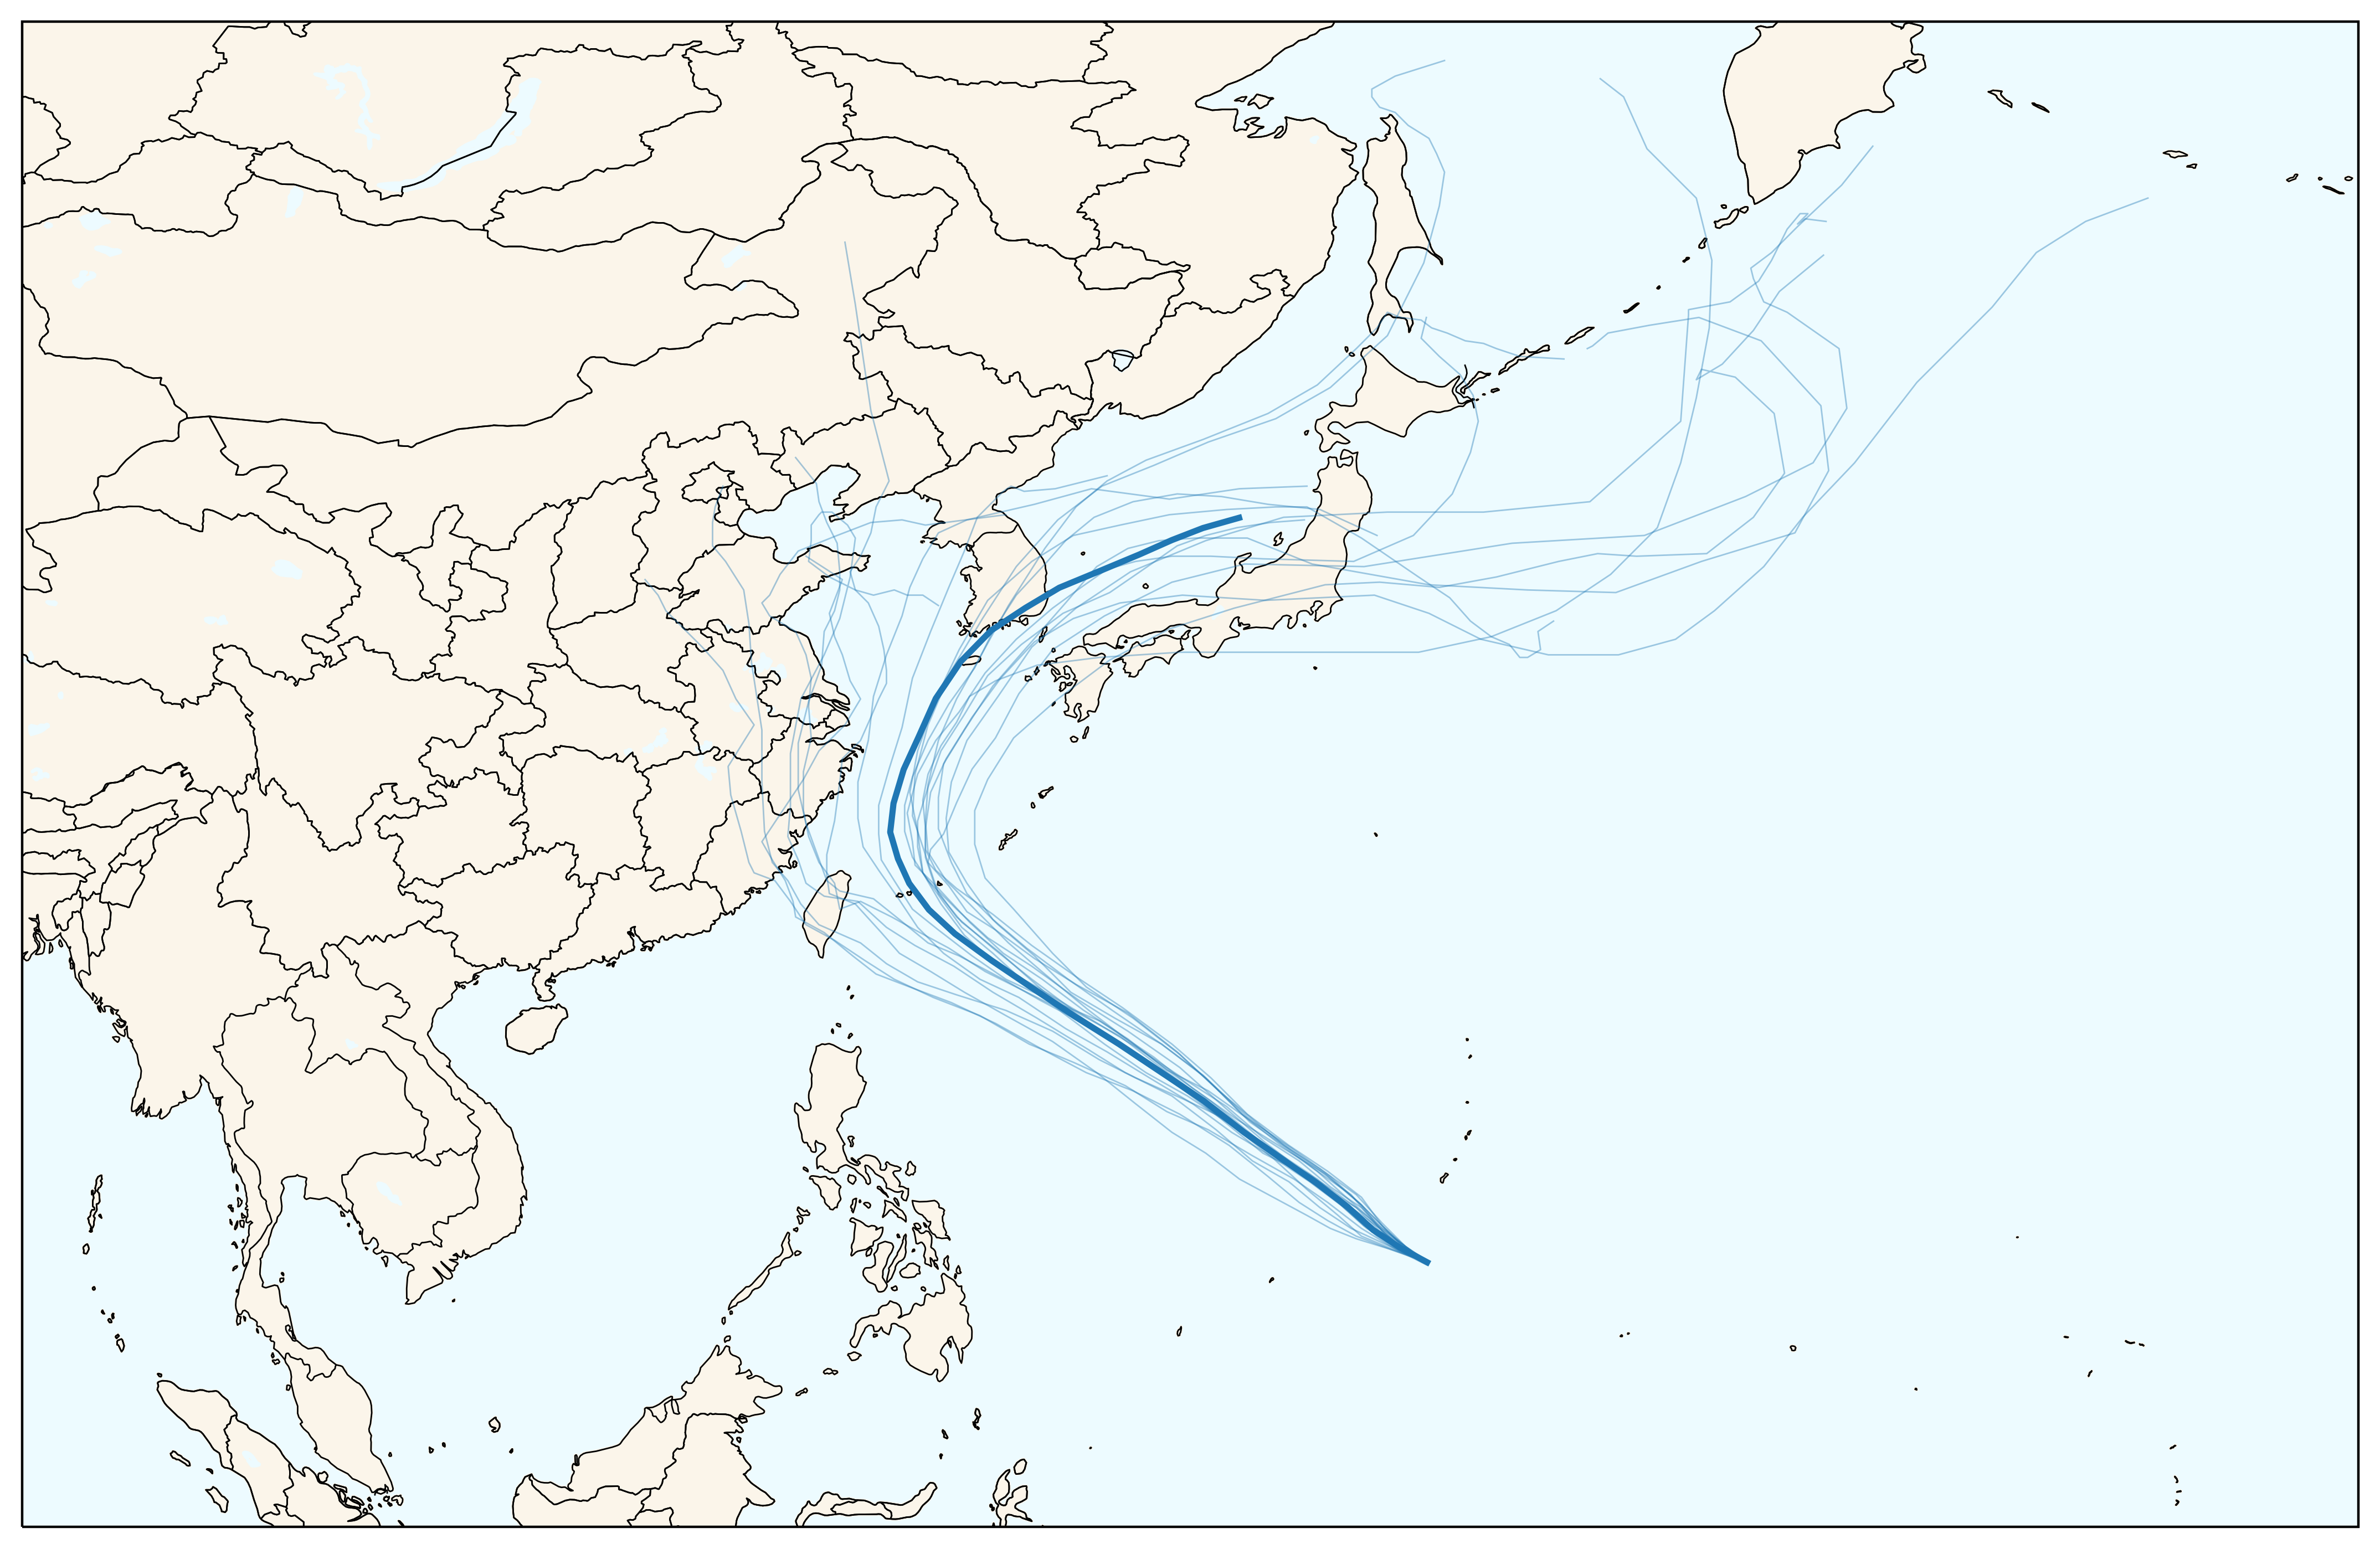

In [43]:
ax = plot(ccrs.PlateCarree()).plot_gridded(ax=None,domain="west_pacific")

lat,lon = [],[]
for i in range(21):
    lat_memb1 = nepartak[nepartak['Ensemble Member']==str(i)]['Latitude (deg N)']
    lon_memb1 = nepartak[nepartak['Ensemble Member']==str(i)]['Longitude (deg E)']
    lonz = np.asarray([float(obj) for obj in lon_memb1.to_list()])
    latz = np.asarray([float(obj) for obj in lat_memb1.to_list()])
    ax.plot(lonz,latz,lw=0.5,alpha=0.4,c='tab:blue')
    lat.append(latz)
    lon.append(lonz)

lonmin_index,latmin_index = np.array([len(obj) for obj in (lon)]).min(),np.array([len(obj) for obj in (lat)]).min()
lon_proc = [obj[:int(lonmin_index)] for obj in lon]
lat_proc = [obj[:int(lonmin_index)] for obj in lat]
ax.plot(np.asarray(lon_proc).mean(axis=0),np.asarray(lat_proc).mean(axis=0),lw=2,alpha=1,c='tab:blue')
plt.show()